In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from numpy.polynomial.polynomial import polyfit
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import statsmodels.stats.tests.test_influence
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## __1 - Business Problem__  
___Classify whether application accepted or not using Logistic regression___  

## __2 - Data collection and description__ 

In [3]:
df = pd.read_csv("../Raw Data/creditcard.csv")

In [4]:
df1 = df.iloc[:,[1,2,3,4,5,6,7,8,9,10,11,12]]

In [5]:
df1

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1314,yes,0,33.58333,4.5660,0.002146,7.333333,yes,no,0,94,1,19
1315,no,5,23.91667,3.1920,0.000376,0.000000,no,no,3,12,1,5
1316,yes,0,40.58333,4.6000,0.026513,101.298300,yes,no,2,1,1,2
1317,yes,0,32.83333,3.7000,0.008999,26.996670,no,yes,0,60,1,7


In [6]:
df1.describe

<bound method NDFrame.describe of      card  reports       age  income     share  expenditure owner selfemp  \
0     yes        0  37.66667  4.5200  0.033270   124.983300   yes      no   
1     yes        0  33.25000  2.4200  0.005217     9.854167    no      no   
2     yes        0  33.66667  4.5000  0.004156    15.000000   yes      no   
3     yes        0  30.50000  2.5400  0.065214   137.869200    no      no   
4     yes        0  32.16667  9.7867  0.067051   546.503300   yes      no   
...   ...      ...       ...     ...       ...          ...   ...     ...   
1314  yes        0  33.58333  4.5660  0.002146     7.333333   yes      no   
1315   no        5  23.91667  3.1920  0.000376     0.000000    no      no   
1316  yes        0  40.58333  4.6000  0.026513   101.298300   yes      no   
1317  yes        0  32.83333  3.7000  0.008999    26.996670    no     yes   
1318  yes        0  48.25000  3.7000  0.111619   344.157500   yes      no   

      dependents  months  majorcards  act

/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

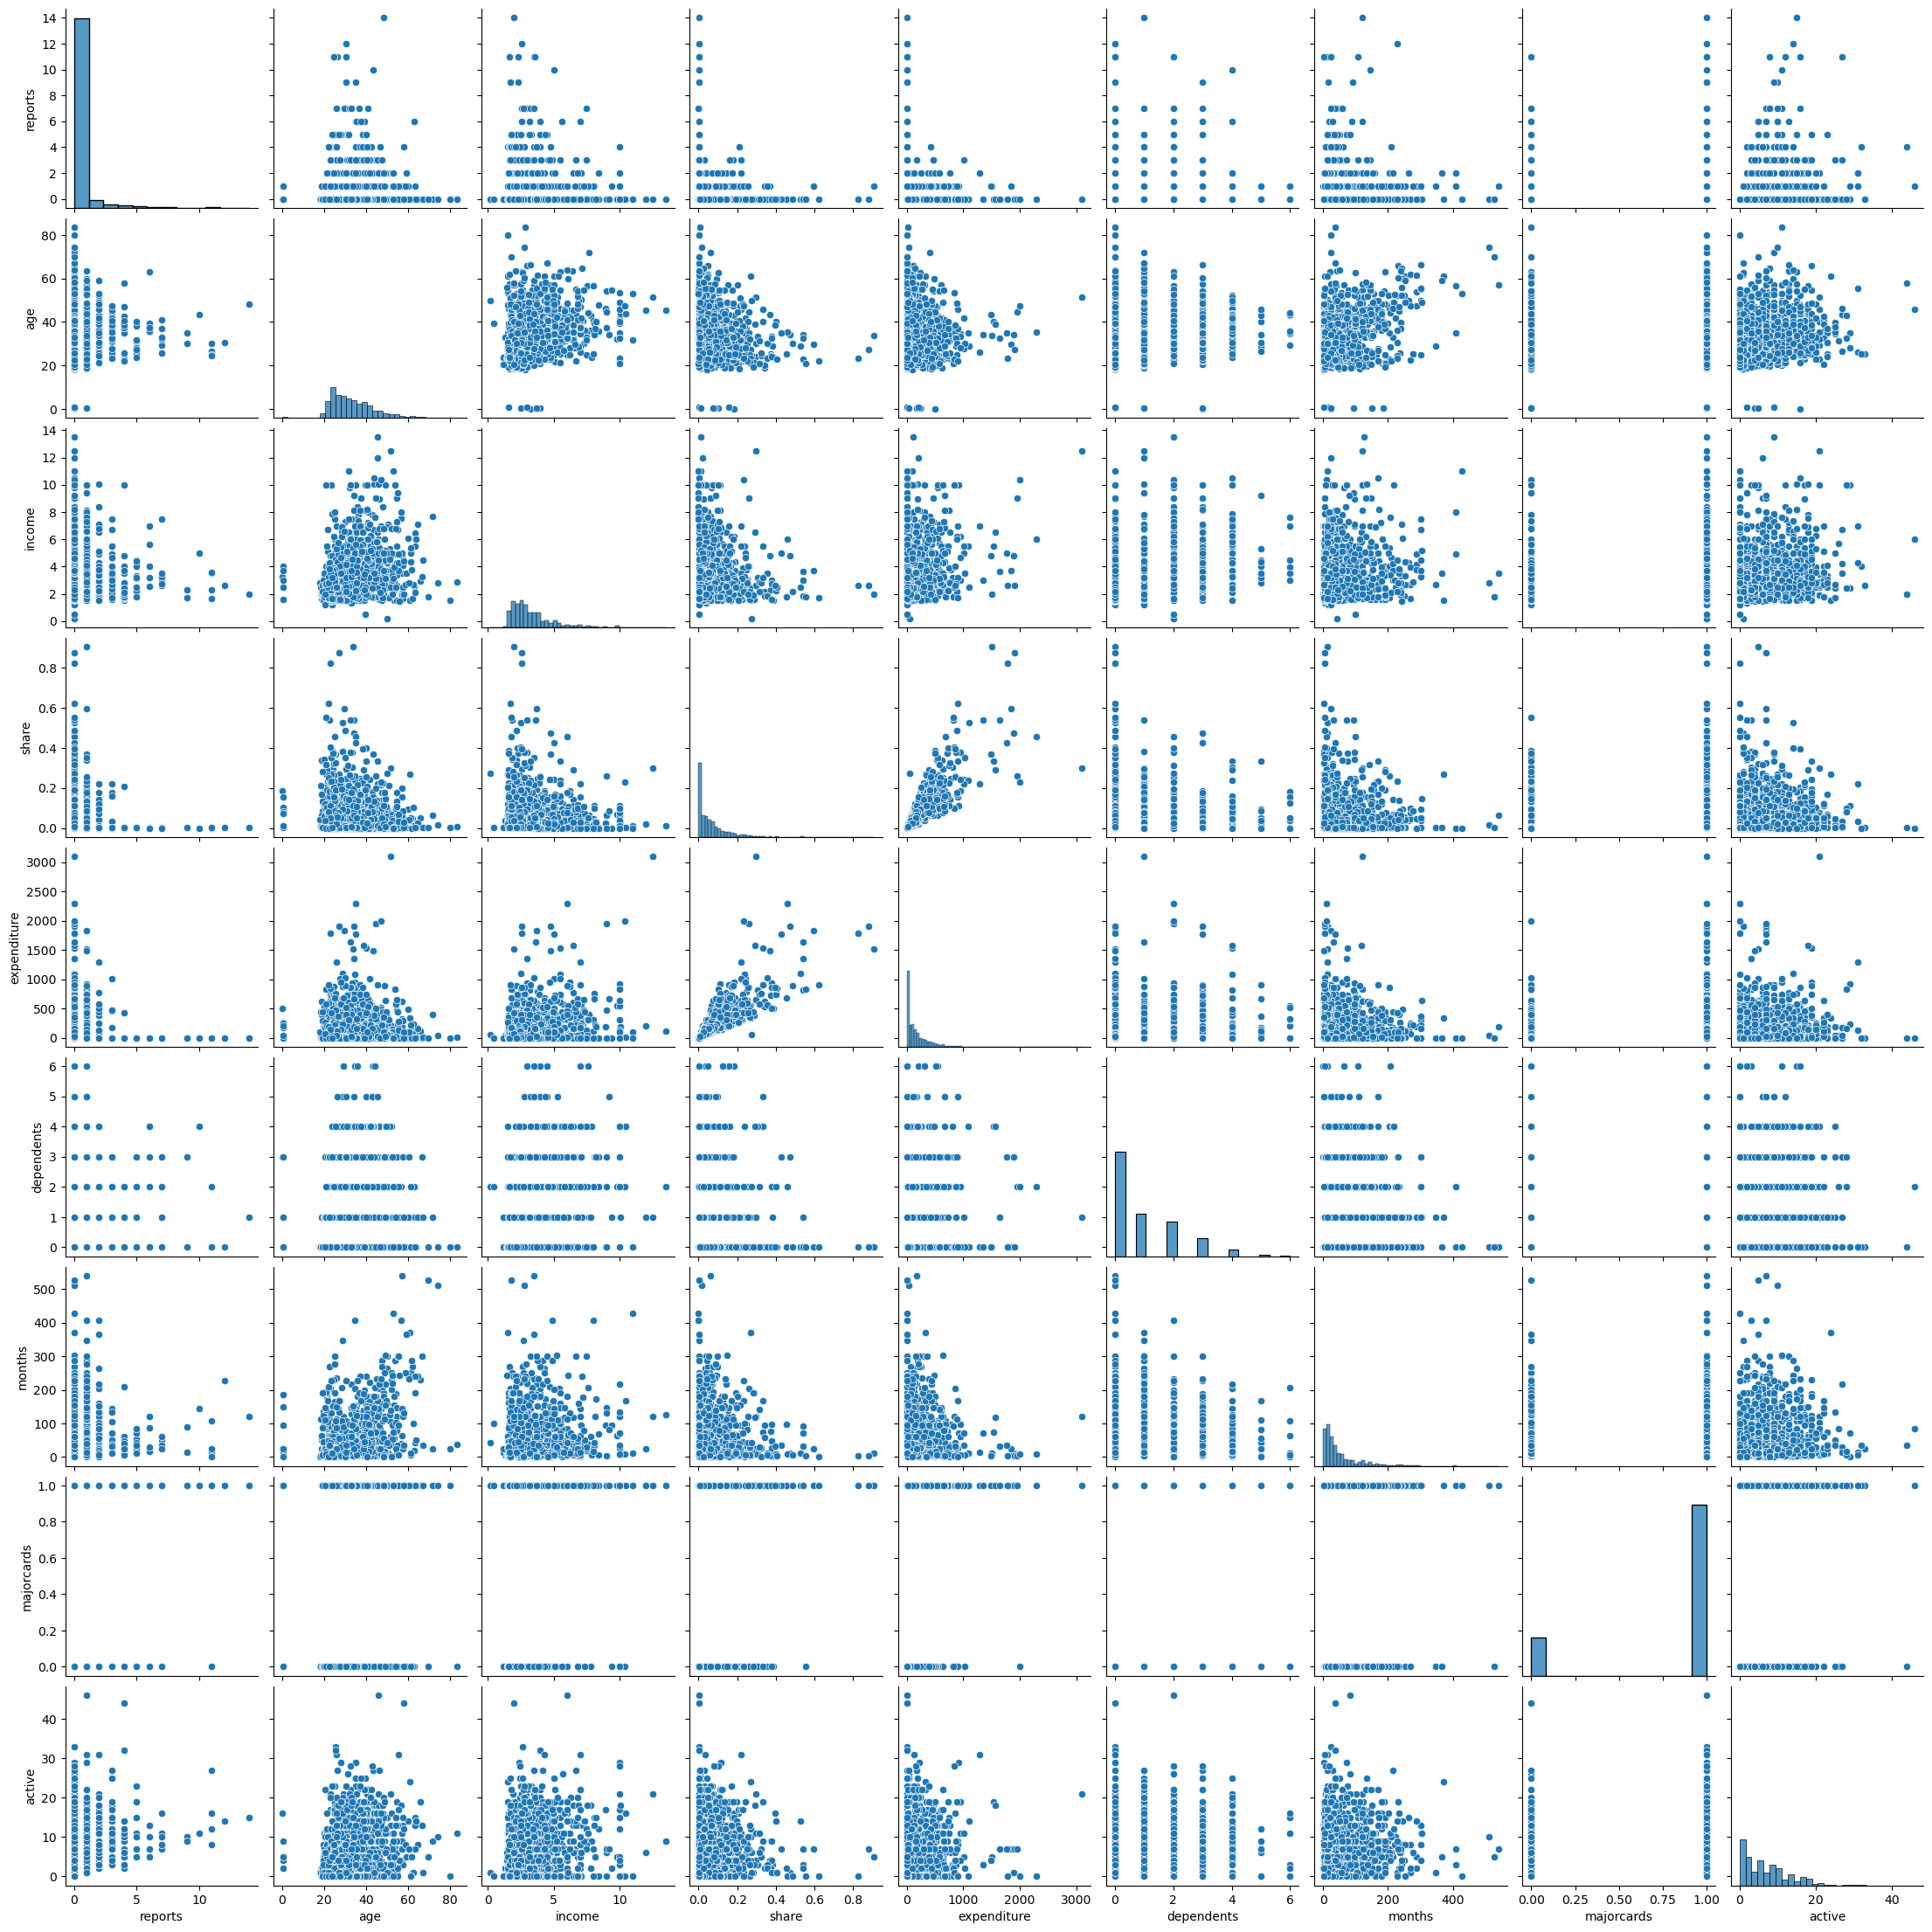

In [7]:
sns.pairplot(df1)

In [8]:
df1['card'].value_counts()

card
yes    1023
no      296
Name: count, dtype: int64

In [9]:
count_no_card = len(df1[df1['card']=="no"])
count_card = len(df1[df1['card']=="yes"])

In [10]:
(count_card / (count_card + count_no_card))*100

77.5587566338135

### Percentage of card acceptance is 77.55 % in the current data set

Text(0, 0.5, 'Frequency')

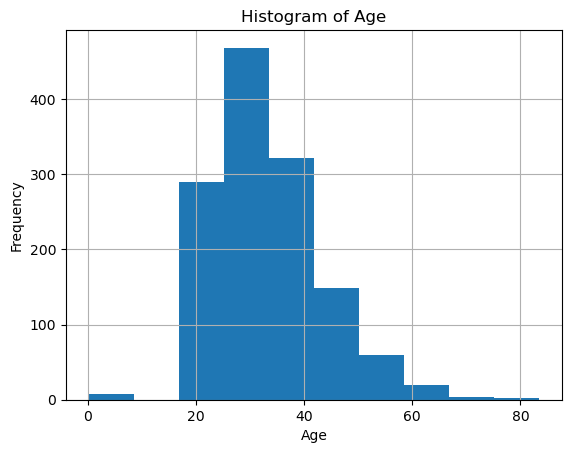

In [11]:
df1.age.hist()
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')

### Most of the customers are in age between 20 and 40 years

Text(0, 0.5, 'Frequency')

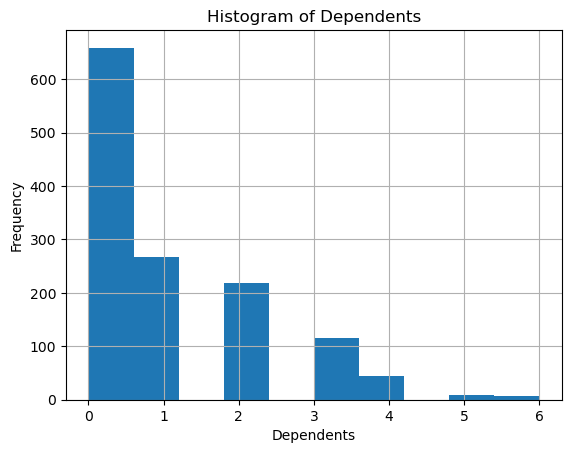

In [12]:
df1.dependents.hist()
plt.title('Histogram of Dependents')
plt.xlabel('Dependents')
plt.ylabel('Frequency')

### Most of the customers 0 - 2 Dependents

Text(0, 0.5, 'Frequency')

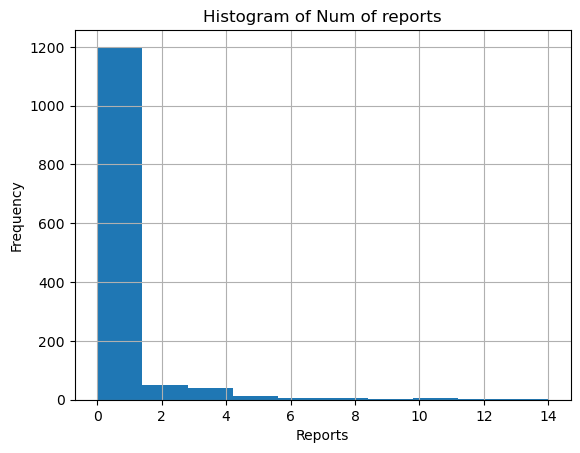

In [13]:
df1.reports.hist()
plt.title('Histogram of Num of reports')
plt.xlabel('Reports')
plt.ylabel('Frequency')

### Most of the customers 0 - 2 Reports

In [14]:
df1['owner'].value_counts()

owner
no     738
yes    581
Name: count, dtype: int64

### Data is somewhat evenly distributed on whether the customer is owner or not

In [15]:
df1['selfemp'].value_counts()

selfemp
no     1228
yes      91
Name: count, dtype: int64

### However majority of the customers are NOT selfemployed

## __3 - Cleaning Data__ 

In [16]:
df1.isnull().sum()

card           0
reports        0
age            0
income         0
share          0
expenditure    0
owner          0
selfemp        0
dependents     0
months         0
majorcards     0
active         0
dtype: int64

### Since there are no Null values in any column we don't have to create any exceptions

## __4 - Logistic Regression Model__ 

In [17]:
df1 ['card'] = df1 ['card'].map({'yes': 1, 'no': 0})

/var/folders/qf/59s2hyj17wx1jdx8qbwchk8w0000gn/T/ipykernel_62499/2478813955.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1 ['card'] = df1 ['card'].map({'yes': 1, 'no': 0})


In [18]:
df1 ['owner'] = df1 ['owner'].map({'yes': 1, 'no': 0})

/var/folders/qf/59s2hyj17wx1jdx8qbwchk8w0000gn/T/ipykernel_62499/1619789914.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1 ['owner'] = df1 ['owner'].map({'yes': 1, 'no': 0})


In [19]:
df1 ['selfemp'] = df1 ['selfemp'].map({'yes': 1, 'no': 0})

/var/folders/qf/59s2hyj17wx1jdx8qbwchk8w0000gn/T/ipykernel_62499/139303440.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1 ['selfemp'] = df1 ['selfemp'].map({'yes': 1, 'no': 0})


In [20]:
X = df1.iloc[:,[1,2,3,4,5,6,7,8,9,10,11]]
y = df1['card']

In [21]:
logreg = LogisticRegression()

In [23]:
rfe = RFE(logreg)
rfe = rfe.fit(X, y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

[ True False False False  True  True False  True False  True False]
[1 5 3 7 1 1 2 1 6 1 4]


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

### As per Recursive Feature Elimination (RFE) analysis we can conclude that all the variables are relevant for the model

In [24]:
logit=sm.Logit(y,X.astype('float'))
result = logit.fit(method='bfgs')

         Current function value: 0.055289
         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39


/opt/homebrew/anaconda3/lib/python3.11/site-packages/scipy/optimize/_optimize.py:1360: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [25]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   card   No. Observations:                 1319
Model:                          Logit   Df Residuals:                     1308
Method:                           MLE   Df Model:                           10
Date:                Sat, 18 May 2024   Pseudo R-squ.:                  0.8962
Time:                        15:26:46   Log-Likelihood:                -72.926
converged:                      False   LL-Null:                       -702.28
Covariance Type:            nonrobust   LLR p-value:                3.102e-264
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
reports        -1.5935      0.567     -2.811      0.005      -2.705      -0.482
age            -0.0353      0.020     -1.767      0.077      -0.074       0.004
income         -0.1880      0.165     -1.139      0.255      -0.512       0.136
share           0.0082    480.370   1.71e-05      1.000    -941.500     941.516
expenditure     0.7384      0.199      3.715      0.000       0.349       1.128
owner           0.6332      0.499      1.269      0.204      -0.345       1.611
selfemp         0.6637      0.595      1.115      0.265      -0.503       1.830
dependents     -0.6577      0.228     -2.880      0.004      -1.105      -0.210
months          0.0015      0.004      0.414      0.679      -0.005       0.008
majorcards     -0.1022      0.447     -0.228      0.819      -0.979       0.775
active          0.0233      0.038      0.621      0.535      -0.050       0.097
===============================================================================

Possibly complete quasi-separation: A fraction 0.73 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

#### Most of the variables have significant except few

In [26]:
logreg.fit(X, y)

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [28]:
y_pred = logreg.predict(X)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X, y)))

Accuracy of logistic regression classifier on test set: 0.98


In [29]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       296
           1       1.00      0.98      0.99      1023

    accuracy                           0.98      1319
   macro avg       0.96      0.99      0.97      1319
weighted avg       0.98      0.98      0.98      1319



In [30]:
confusion_matrix(y, y_pred)

array([[ 295,    1],
       [  23, 1000]])

## __5 - Output Interpretation__ 

1 - Confusion Matrix  
The result is telling us that we have 295+1000 correct predictions and 23+1 incorrect predictions.

2 - Accuracy == 98%   
Of the entire data set, 98% of the card application will be accepted